In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import skimage.color
import skimage.filters
import skimage.io
import skimage.feature
import skimage.viewer
import skimage.measure
import skimage.color
%matplotlib inline

/home/srivathsan/.local/lib/python3.6/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


### Utility functions

In [2]:
# Scaling or clipping
scale = lambda x : (255 * (x - np.min(x))) / (np.max(x) - np.min(x))
inrange = lambda x: np.where(x > 255, 255, np.where(x < 0, 0, x))
invert = lambda x: np.max(x) - x
print_range = lambda x: print(np.min(x), np.max(x))

### Image input and pre processing

In [3]:
input_texture = cv2.imread('../images/input.png')
input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

In [4]:
def apply_filter(im, filt, zero_padding=False):
    
    wdth = filt.shape[0]//2
    
    filt_img = np.zeros(im.shape)
    
    if zero_padding:
        im = np.vstack( (np.zeros( (wdth, im.shape[1]) ), im, np.zeros( (wdth, im.shape[1]) ) ) )
        im = np.hstack( (np.zeros( (im.shape[0], wdth) ), im, np.zeros( (im.shape[0], wdth) ) ) )
    else:
        im = np.vstack(([im[0]]*wdth, im, [im[-1]]*wdth))
        im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*wdth)))

    for i in range(wdth, im.shape[0]-wdth):
        for j in range(wdth, im.shape[1]-wdth):
            filt_img[i-wdth][j-wdth] = np.sum(im[i-wdth:i+wdth+1, j-wdth:j+wdth+1] * filt)
    
    return np.rint(filt_img)

prewitt =  [np.array([
                [-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]
        ]) , np.array([
                [ 1,  1,  1],
                [ 0,  0,  0],
                [-1, -1, -1]
        ])]


In [5]:
def decouple(img):
    
    img = img.astype('float64')
    
    with np.errstate(divide='ignore', invalid='ignore'):
        intensity_layer = np.nan_to_num(np.true_divide(((img[:, :, 0]**2) + (img[:, :, 1]**2) + (img[:, :, 2]**2)) , (img[:,:,0]+img[:, :, 1]+img[:, :, 2])))
        intensity_layer = np.rint(intensity_layer).astype('uint8')
        dx = apply_filter(intensity_layer, prewitt[0])
        dy = apply_filter(intensity_layer, prewitt[1])
        gradient = np.nan_to_num(np.arctan(dy/dx)) 

    
    return intensity_layer,gradient

In [6]:
details, gradient = decouple(input_texture)

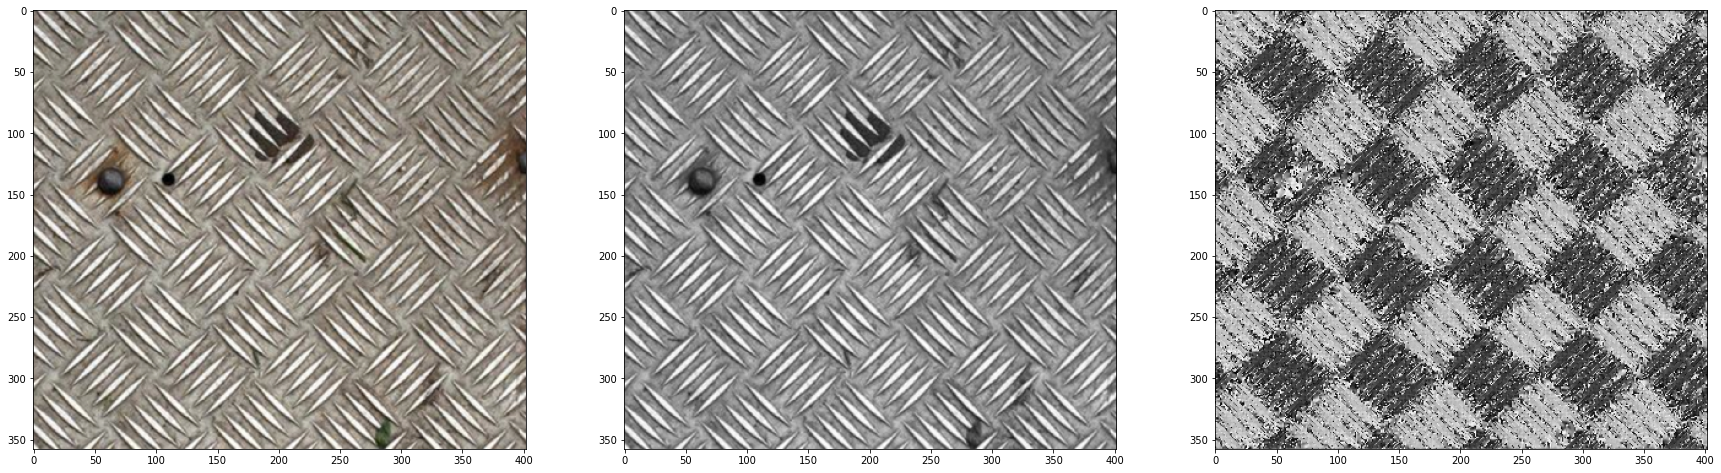

In [7]:
plt.figure(figsize = (30, 30))

plt.subplot(131)
plt.imshow(input_texture, cmap='gray')

plt.subplot(132)
plt.imshow(details, cmap='gray')

plt.subplot(133)
plt.imshow(gradient, cmap='gray')

plt.show()

## Distance function

In [8]:
def distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2

    tI = np.vstack(([tI[0]]*wdth_y, tI, [tI[-1]]*(Y-wdth_y)))
    tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x))))

    tG = np.vstack(([tG[0]]*wdth_y, tG, [tG[-1]]*(Y-wdth_y)))
    tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x))))
   
    g_img = np.zeros((M, N))
    l_img = np.zeros((M, N))
   
    for i in range(wdth_y, wdth_y+M):
        for j in range(wdth_x, wdth_x+N):
            try:
                g_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sG - tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
                l_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sI - tI[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            except Exception:
                print("Source shape: ", sG.shape, "  i, j:", i, j, "   Patch shape:",  tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x].shape)
                raise Exception
            
    return (g_img / np.max(g_img)) + (l_img / np.max(l_img))

In [9]:
def inbuilt_distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2
    try:
        if wdth_y:
            tI = np.vstack(([tI[0]]*wdth_y, tI))
            tG = np.vstack(([tG[0]]*wdth_y, tG))
        if Y-wdth_y-1:
            tI = np.vstack((tI, [tI[-1]]*(Y-wdth_y-1)))
            tG = np.vstack((tG, [tG[-1]]*(Y-wdth_y-1)))
        
        if wdth_x:
            tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI))
            tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG))
        if X-wdth_x-1:
            tI = np.hstack((tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            tG = np.hstack((tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            
    except Exception:
        print("\n", wdth_x, wdth_y, Y-wdth_y-1, X-wdth_x-1)
        raise Exception   

    lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF_NORMED)
    grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF_NORMED)
    
    return invert(lum+grd)

In [10]:
def median_filter(im, k):
        
    filt_img = np.zeros(im.shape)

    wdth = k//2

    im = np.vstack(([im[0]]*wdth, im, [im[-1]]*(k-wdth)))
    im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*(k-wdth))))

    for j in range(wdth, im.shape[1]-wdth):
        for i in range(wdth, im.shape[0]-wdth):
            x = np.median(im[i-wdth:i+k-wdth+1, j-wdth:j+k-wdth+1])
            filt_img[i-wdth][j-wdth] = x
    return filt_img

## Age Map function

In [11]:
def age(source_patch, target, K):
    
    sI, sG = source_patch
    tI, tG = target
    dist_mat = inbuilt_distance(sI, sG, tI, tG)
#     discrete = np.rint(scale(dist_mat)).astype('uint8')
    # discrete = median_filter(discrete, sI.shape[0]//2 + sI.shape[0]%2 - 1)
#     size = sI.shape[0]//2
#     size = max(1, size + (1-(size%2)))
#     discrete = cv2.medianBlur(discrete, size)

    K_distances = np.sort(dist_mat.flatten())[:K]
#     K_distances = np.sort(np.unique(discrete).flatten())[:K]
#     co_ords = []
#     for i in K_distances:
#         x, y = np.where(discrete == i)
#         for j in zip(x, y):
#             co_ords.append(j)

#     K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]
#     K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]

#     return np.average(K_neighbours)
    return np.average(K_distances)



In [12]:
def generate_age_map(I, G, N, K):

    age_map = np.zeros(I.shape, dtype=('float64'))

    for i in range(0, I.shape[0], N):
        for j in range(0, I.shape[1], N):
            x1, x2 = i, min(I.shape[0], i+N)
            y1, y2 = j, min(I.shape[1], j+N)
            age_map[x1:x2, y1:y2] = age( (I[x1:x2, y1:y2], G[x1:x2, y1:y2]) , (I, G), K)

    return age_map


## Colormap

In [13]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

heatmap = make_colormap(
    [c('blue'), c('aqua'), 0.33, c('aqua'), c('yellow'), 0.66, c('yellow'), c('red')])

# Testing for age map

#### Temp

In [14]:
N = 20
# x=205-5
# y=70+6
x=0
y=0

In [15]:
source_patch_one = input_texture[x:x+N, y:y+N, :]
source_patch_l = details[x:x+N, y:y+N]
source_patch_g = gradient[x:x+N, y:y+N]

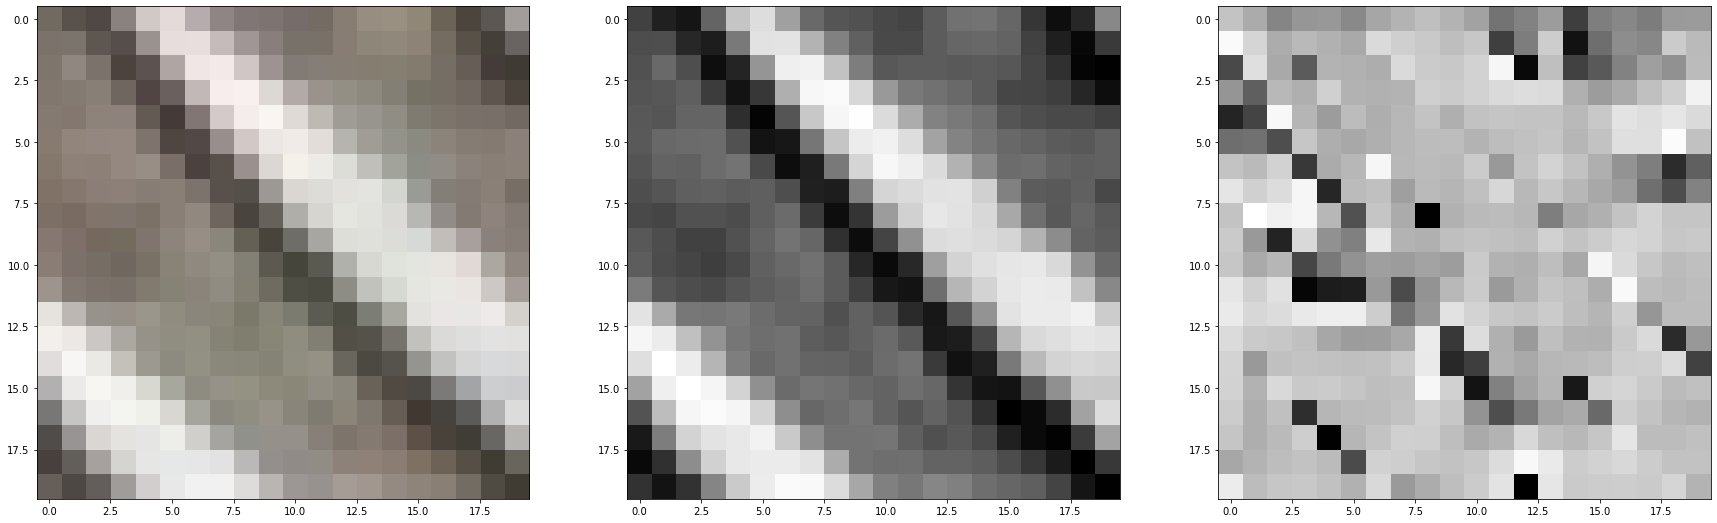

In [16]:
plt.figure(figsize = (30, 30))

plt.subplot(131)
plt.imshow(source_patch_one, cmap='gray')

plt.subplot(132)
plt.imshow(source_patch_l, cmap='gray')

plt.subplot(133)
plt.imshow(source_patch_g, cmap='gray')

plt.show()

In [17]:
%%time
for_2_inbuilt = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)

CPU times: user 28 ms, sys: 11.4 ms, total: 39.4 ms
Wall time: 1.43 s


In [18]:
b = np.rint(scale(for_2_inbuilt)).astype('uint8')
med = cv2.medianBlur(b, 9)
# med = cv2.erode(b, np.ones((9, 9), dtype='int'))

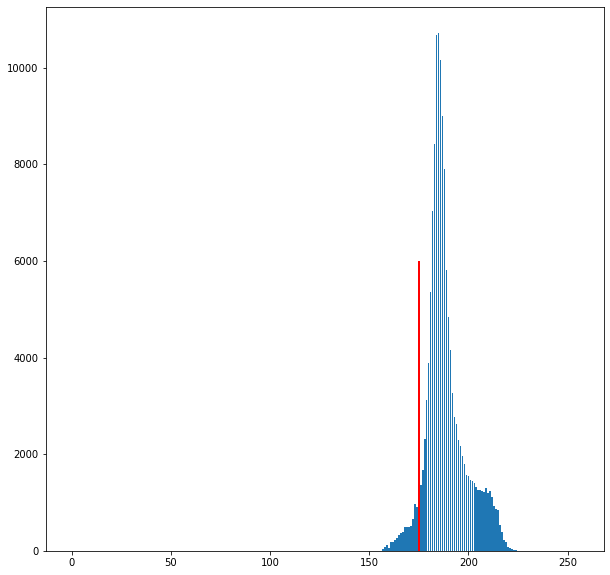

In [19]:
plt.figure(figsize=(10, 10))
plt.bar(range(256), np.bincount(med.flatten(), minlength=256))
plt.bar(range(256), [6000 if i==175 else 0 for i in range(256)], color='red')
plt.show()

In [20]:
print_range = lambda x: print(np.min(x), np.max(x))

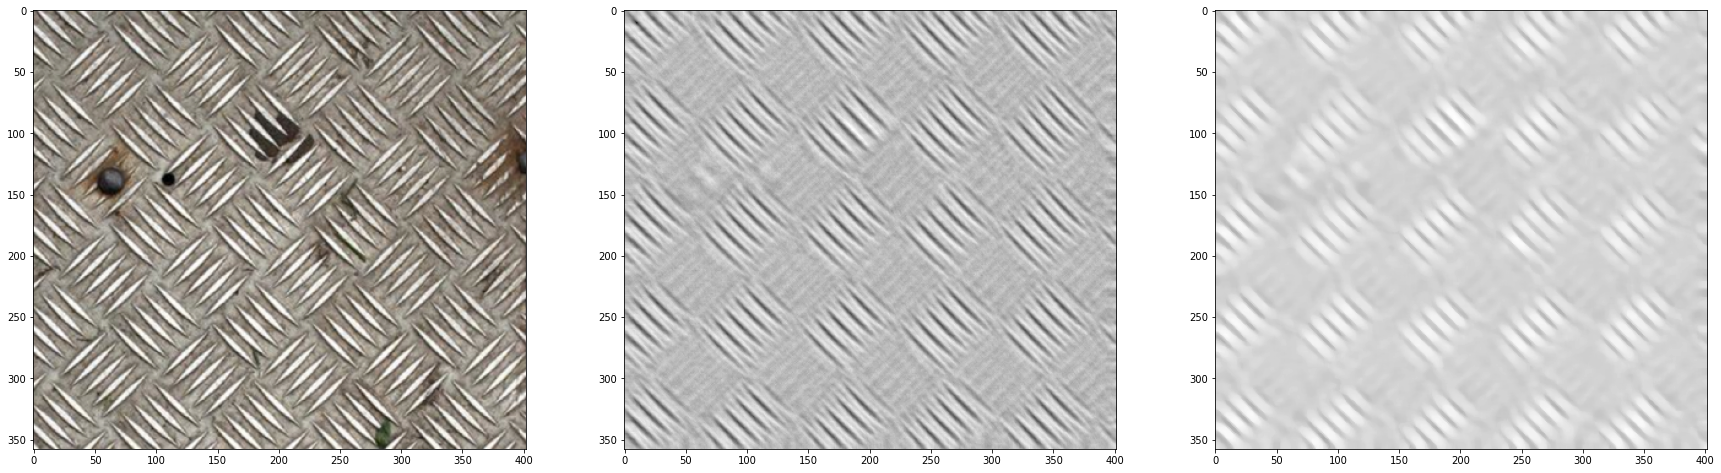

In [21]:
plt.figure(figsize=(30, 10))

plt.subplot(131).imshow(input_texture, cmap='gray')
plt.subplot(132).imshow(b, cmap='gray')
plt.subplot(133).imshow(med, cmap='gray', vmin=0)

plt.show()

In [22]:
K2_distances = np.sort(for_2_inbuilt.flatten())

In [23]:
K2_distances

array([0.        , 0.6955215 , 0.71779954, ..., 2.744288  , 2.7514539 ,
       2.7540228 ], dtype=float32)

In [24]:
(np.mean(K2_distances[:int(0.002*len(K2_distances))]))

0.91048586

In [25]:
co_ords2 = np.array([[-1, -1]])
d = 0
for i in K2_distances:
    x, y = np.where(med==i)
    flag=False
    for j in zip(x, y):
        if not np.any(np.abs(co_ords2[1:] - j) < [15, 15]):
            co_ords2 = np.vstack((co_ords2, np.array(j)))
            flag=True
    if flag: 
        d = d+1
    if d == 10:
        break
        

In [26]:
print(co_ords2[:])

[[-1 -1]]


In [27]:
K2_neighbours = [for_2_inbuilt[x, y] for (x, y) in co_ords2[1:]]
K2_neighbours2 = [b[x, y] for (x, y) in co_ords2[1:]]

In [28]:
print(np.average(K2_neighbours), np.average(K2_neighbours2))

nan nan


/home/srivathsan/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/srivathsan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


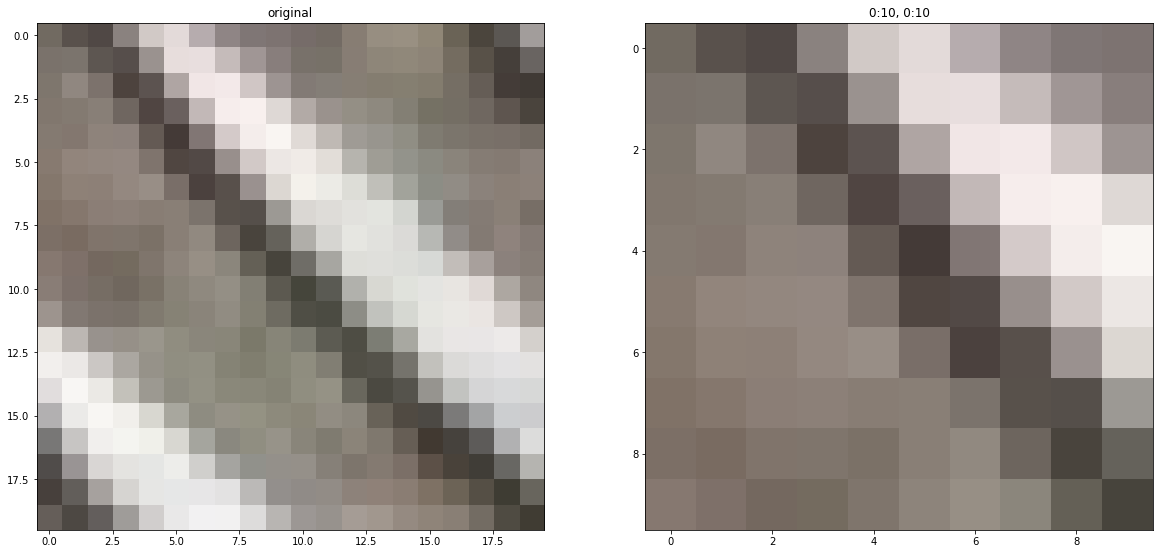

In [29]:
for (i, j) in co_ords2:
    min_x = max(i-10, 0)
    min_y = max(j-10, 0)
    max_x = min(i+11, input_texture.shape[0])
    max_y = min(j+11, input_texture.shape[1])
    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.imshow(source_patch_one)
    plt.title("original")

    plt.subplot(122)
    plt.imshow(input_texture[min_x:max_x, min_y:max_y])
    plt.title(f"{min_x}:{max_x}, {min_y}:{max_y}")
    plt.show()

### Final

In [30]:
%%time
age_map = generate_age_map(details, gradient, 20, 100)

CPU times: user 6.96 s, sys: 10 µs, total: 6.96 s
Wall time: 6.96 s


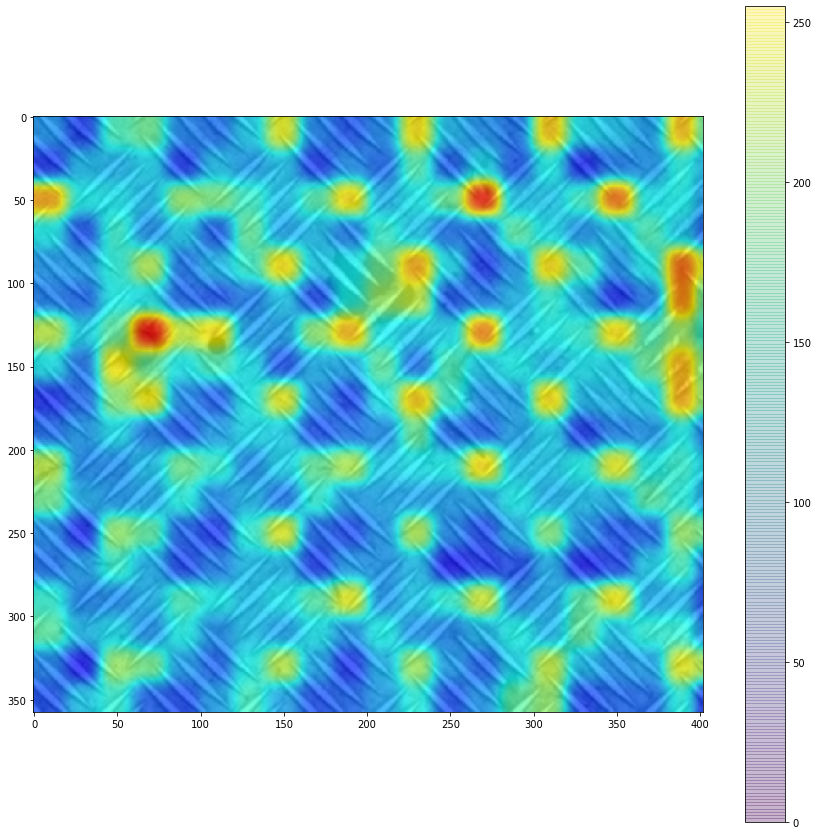

In [31]:
plt.figure(figsize=(15, 15))
# plt.imshow(age_map, cmap=heatmap, alpha=1)
plt.imshow(cv2.GaussianBlur(age_map,(25, 25),0), cmap=heatmap, alpha=1)
plt.imshow(input_texture, alpha=0.3)
plt.colorbar()
plt.show()

In [32]:
%%time
age_map2 = generate_age_map(details2, gradient2, 20, 100)

NameError: name 'details2' is not defined

In [33]:
plt.figure(figsize=(15, 15))
# plt.imshow(age_map2, cmap=heatmap, alpha=1)
plt.imshow(cv2.GaussianBlur(age_map2,(23, 23),0), cmap=heatmap, alpha=1)
plt.imshow(inp2, alpha=0.3)
plt.colorbar()
plt.show()

NameError: name 'age_map2' is not defined

<Figure size 1080x1080 with 0 Axes>

# Tile detection 

In [11]:
a,b,c=input_texture.shape

N = a//3

source_patch_one = input_texture[a//4:a//4+N,b//4:b//4+N, :]
source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]


In [12]:
%%time
dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)

CPU times: user 39.2 ms, sys: 413 µs, total: 39.6 ms
Wall time: 38.6 ms


(-0.5, 401.5, 357.5, -0.5)

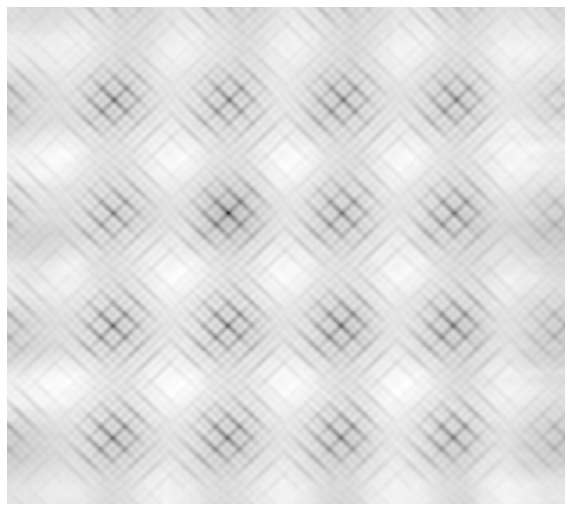

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(dist_map ,cmap='gray')
plt.axis('off')

In [14]:
def local_minimas(dist_map,N):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N):
        for j in range(0,b,N):
            X=min(i+N,a)
            Y=min(j+N,b)
            patch=dist_map[i:X,j:Y]
            thresh=np.unique(patch)[np.rint(0.005*(X-i)*(Y-j)).astype('uint8')]
#             plt.figure(figsize=(10,10))
#             plt.imshow(patch<thresh,cmap='gray')
#             plt.axis('off')
            minima[i:X,j:Y]=patch<thresh     
                      
    return minima.astype('uint8')                  
                      
                      
                      
                     


In [15]:
def global_minimas(dist_map,N):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    
    thresh=np.unique(dist_map)[np.rint(0.005*(a-1)*(b-1)).astype('uint8')]
#   plt.figure(figsize=(10,10))
#   plt.imshow(patch<thresh,cmap='gray')
#   plt.axis('off')
    minima=dist_map<thresh     
                      
    return minima.astype('uint8')                  
                      

In [16]:
local_mask=local_minimas(dist_map,N)

In [17]:
global_mask=global_minimas(dist_map,N)

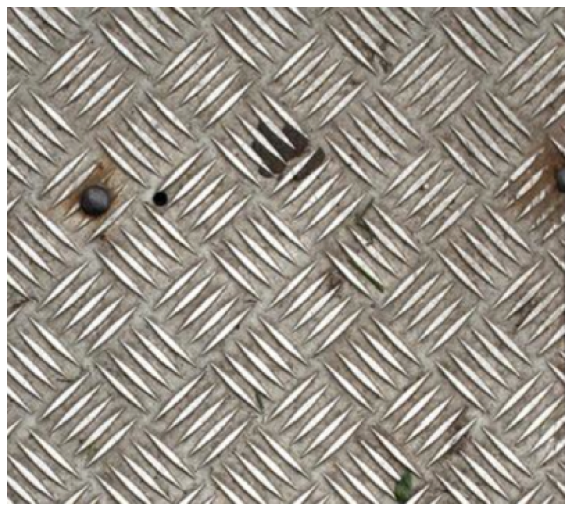

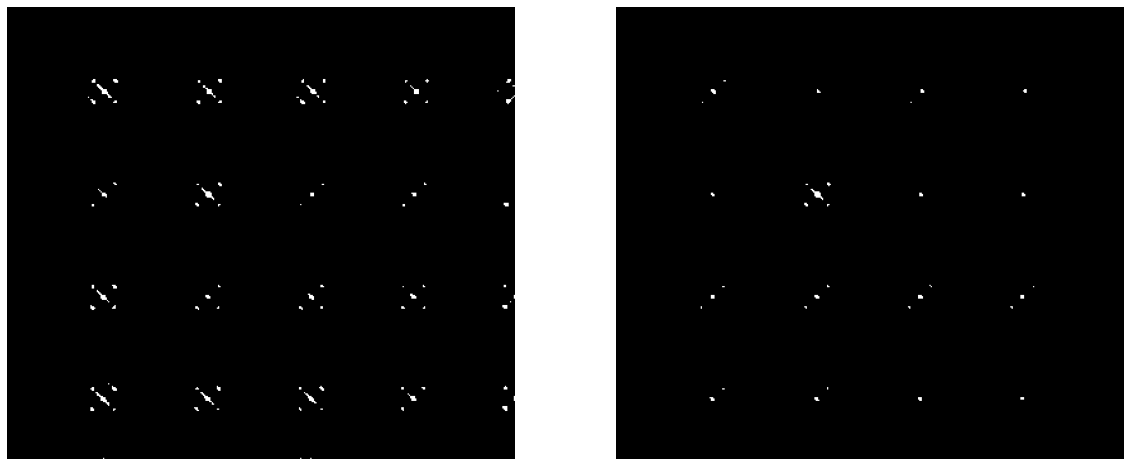

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(input_texture)
plt.axis('off')
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(local_mask,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(global_mask,cmap='gray')
plt.axis('off')
plt.show()

In [106]:
inp2=cv2.imread('../images/texture4.jpeg')
inp2=cv2.cvtColor(inp2,cv2.COLOR_BGR2RGB)

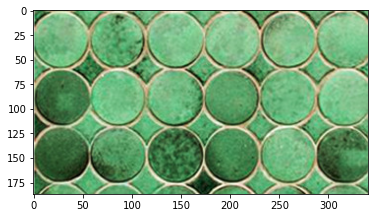

In [107]:
plt.imshow(inp2)

In [108]:
details2, gradient2 = decouple(inp2)

In [109]:
a,b,c=inp2.shape

N2 = a//3

source_patch_one = inp2[a//4:a//4+N2,b//4:b//4+N2, :]
source_patch_l = details2[a//4:a//4+N2,b//4:b//4+N2]
source_patch_g = gradient2[a//4:a//4+N2,b//4:b//4+N2]


dist_map2 = inbuilt_distance(source_patch_l, source_patch_g, details2, gradient2)

(-0.5, 340.5, 186.5, -0.5)

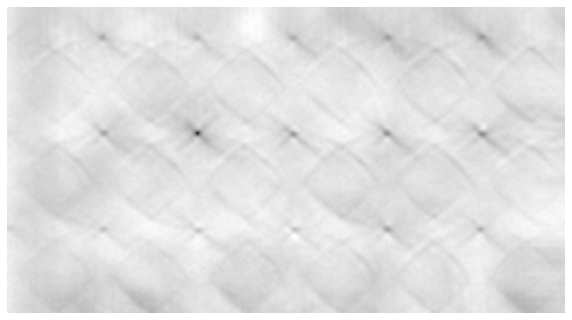

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(dist_map2,cmap='gray')
plt.axis('off')

In [111]:
l2=local_minimas(dist_map2,N2)
g2=global_minimas(dist_map2,N2)

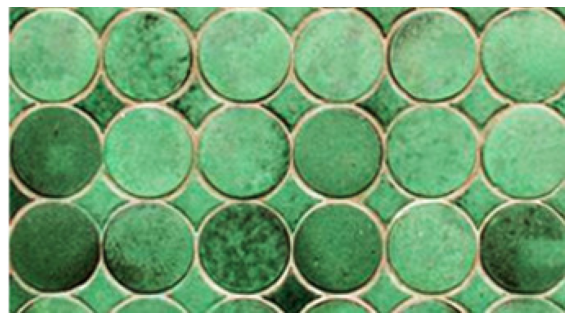

In [112]:
plt.figure(figsize=(10,10))
plt.imshow(inp2)
plt.axis('off')
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(l2,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(g2,cmap='gray')
plt.axis('off')
plt.show()

In [113]:
g1_bin= cv2.threshold(global_mask, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
g2_bin= cv2.threshold(g2, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

ret1, labels1 = cv2.connectedComponents(g1_bin)
ret2, labels2 = cv2.connectedComponents(g2_bin)



In [114]:
def make_tile(luminance, gradient,labels):
    a,b=luminance.shape
    N=a//3
    check=np.unique(labels)[1:]
    tiles={}
    global_min={}
#     dummy={}
    
    for i in check:
#         dummy_i=np.zeros((a,b),dtype='uint8')
        temp=np.where(labels==i)
        l=len(temp[0])
        x=temp[0][l//2]
        y=temp[1][l//2]
        grad_tile=gradient[ max(0,x-N//2):min(x+N//2,a-1) , max(0,y-N//2):min(b-1,y+N//2) ]
        lum_tile=luminance[ max(0,x-N//2):min(x+N//2,a-1) , max(0,y-N//2):min(b-1,y+N//2) ]
#         print(lum_tile.shape,' ' , grad_tile.shape, ' ', a,b)
#         print(max(0,x-N//2),":",min(x+N//2,a-1) ,"      ", max(0,y-N//2),":",min(b-1,y+N//2))
#         dummy_i[ max(0,x-N//2):min(x+N//2,a-1) , max(0,y-N//2):min(b-1,y+N//2) ]=1
        tiles[i]=inbuilt_distance(lum_tile, grad_tile, luminance, gradient)
        global_min[i]=global_minimas(tiles[i],N)
#         dummy[i]=dummy_i
    return global_min

In [115]:

details, gradient = decouple(input_texture)

In [116]:
%%time
pot_tiles=make_tile(details2,gradient2,labels2)

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 138 ms


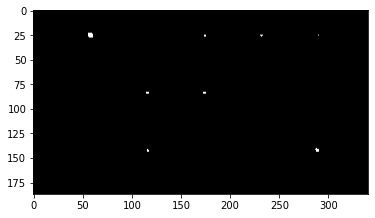

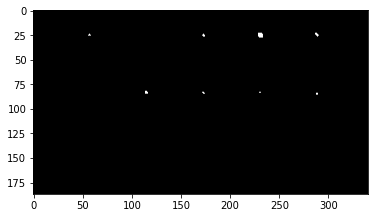

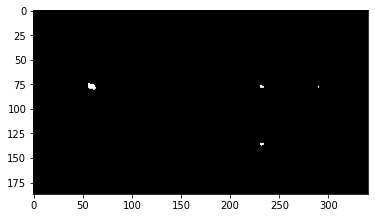

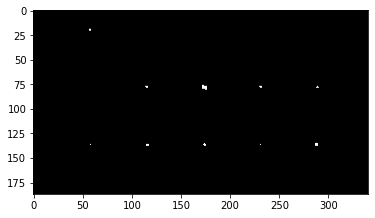

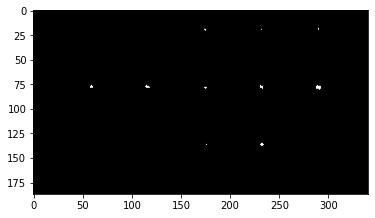

In [117]:
for i in pot_tiles:
    plt.imshow(pot_tiles[i],cmap='gray')
    plt.show()

In [118]:
a,b=pot_tiles[1].shape
sum_tiles=np.zeros((a,b),dtype='uint8')
for i in pot_tiles:
    sum_tiles+=pot_tiles[i]
print(np.unique(sum_tiles))    


[0 1 2 3 4 5 6]


In [119]:
plt.figure(figsize=(10, 10))
plt.imshow(sum_tiles, cmap='gray')
plt.show()

In [120]:
def detect_peaks_local(sum_tiles, N):
    a,b= sum_tiles.shape
    maxima = np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N):
        for j in range(0,b,N):
            X=min(i+N,a)
            Y=min(j+N,b)
            patch=sum_tiles[i:X,j:Y]
            thresh = np.max(patch)

            if thresh > 0:
                maxima[i:X,j:Y] = patch == thresh
                maxima[maxima == 1] = 255
            else:
                maxima[i:X,j:Y] = patch
    return maxima.astype('uint8')                  

#     se = np.ones((N,N))
#     peak_coords = skimage.morphology.local_maxima(sum_tiles,se)
#     print(peak_coords)
#     return peak_coords


    ## Using skimage local maxima gives errors as dimension of structuring element does not match with image. 
    ## Without SE , multiple local maximas are getting detected. Rectifying might give better results than local minima code.

In [121]:
final_tile_centers = detect_peaks_local(sum_tiles,N)

# print(sum_tiles[sum_tiles!=0])
print(np.nonzero(final_tile_centers))
# print(len(final_tile_centers))
final_tile_centers[final_tile_centers!=0] = 255
fig,ax = plt.subplots(2,figsize=(10,10))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(sum_tiles , cmap = 'gray')
ax[1].imshow(final_tile_centers, cmap= 'gray')

(array([ 77,  77,  77,  77,  78,  78, 135, 135, 135, 135, 135, 136, 136,
       136, 136, 136, 136, 136, 137, 137, 137, 140, 141, 141, 141, 141,
       142, 142, 142, 143, 143, 143]), array([ 58,  59, 231, 232, 232, 290,  60, 232, 287, 288, 289,  58,  60,
       232, 233, 287, 288, 289, 287, 288, 289, 288, 287, 288, 289, 290,
       288, 289, 290, 288, 289, 290]))


In [125]:
## Finding the Offset Vectors
Tile_centers = []
x,y = np.nonzero(final_tile_centers)[0],np.nonzero(final_tile_centers)[1]

for c in range(x.shape[0]):
    Tile_centers.append([x[c] , y[c]])
Tile_centers = np.array(Tile_centers)
Offset_Vectors = []
for i in range(Tile_centers.shape[0]):
    for j in range(i+1,Tile_centers.shape[0]):
            Offset_Vectors.append(Tile_centers[i]- Tile_centers[j])
# Offset_Vectors = np.array(Offset_Vectors)
u,c = np.unique(Offset_Vectors,axis = 0, return_counts=True)
sorted_arr = u[c.argsort()]
# print(len(u))
print(sorted_arr)
# print("Two of the most common vectors are ")
# print(sorted_arr[-1],sorted_arr[-2], sorted_arr[-3])
# print("These form the basis of the grid")

[[ -66 -232]
 [ -57  230]
 [  -8 -230]
 [  -8 -229]
 [  -8 -228]
 [  -8  -58]
 [  -8  -57]
 [  -8  -56]
 [  -8   -3]
 [  -8    1]
 [  -7 -232]
 [  -7 -231]
 [   0 -230]
 [   0 -231]
 [  -7  -55]
 [  -1  231]
 [ -57  172]
 [ -57   58]
 [ -57    3]
 [ -57    2]
 [ -58  -58]
 [   0 -175]
 [ -58   -2]
 [ -58    1]
 [ -58    2]
 [ -58    3]
 [ -58   57]
 [  -1  230]
 [ -58   58]
 [ -58  174]
 [ -58  230]
 [ -58  232]
 [ -57  -56]
 [ -57  -55]
 [ -57    0]
 [ -57    1]
 [ -58  171]
 [ -58 -173]
 [  -6 -232]
 [  -1  228]
 [  -1  -58]
 [  -1  -59]
 [  -1 -172]
 [  -4    2]
 [  -3   -2]
 [  -3    1]
 [  -2 -229]
 [  -2 -228]
 [  -2 -227]
 [  -2  -57]
 [  -2  -56]
 [  -2  -55]
 [  -2   -3]
 [  -1 -174]
 [  -1 -232]
 [  -4   -3]
 [  -4  -55]
 [  -4  -56]
 [  -4 -228]
 [  -6 -227]
 [  -1  227]
 [  -1  174]
 [  -1  172]
 [  -1   57]
 [  -1   54]
 [  -6    2]
 [  -6 -231]
 [  -5 -232]
 [  -5 -227]
 [  -5  -58]
 [  -1   -3]
 [  -5  -54]
 [  -1  -54]
 [  -5    2]
 [  -4 -230]
 [  -5 -231]
 [ -58 -174]

In [126]:
plt.imshow(inp2[0:64, 0:56])

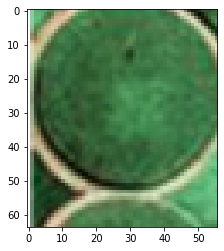

In [127]:
plt.imshow(inp2[64:128, 0:56])


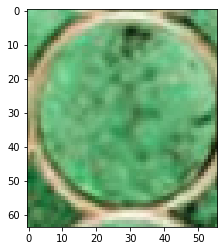

In [128]:
plt.imshow(inp2[0:64, 56:112])

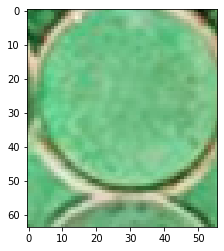

In [129]:
plt.imshow(inp2[64:128, 56:112])